# Team Creation

Here, the Main Teams and their Subteams are created.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf
from helper_functions import setup
from helper_functions.classes.sport_event import SportEvent
from helper_functions.setup.match_scheduling import determine_rotated_matchups_for_sport, write_match_backup
from helper_functions.classes.match import Match
from helper_functions.classes.player import Player
from helper_functions.setup.setup_util import update_player_signup_status
from itertools import combinations
import pandas as pd
from itertools import combinations
from datetime import datetime, timedelta, time, date
hf.LOGGER.setLevel("INFO")

NUM_TEAMS = 3

def try_switch_subteam(player_a: str, player_b: str, sport: str, subteams: list[hf.Subteam]):
    """Tries to switch two players between the given subteams"""
    subteams = [s for s in subteams if s.sport == sport]
    s_a = [s for s in subteams if player_a in s.players]
    s_b = [s for s in subteams if player_b in s.players]
    if len(s_a) == 0 or len(s_b) == 0:
        return
    s_a[0].switch_player_with_other(player_a, player_b, s_b[0])


## Determine Subteam specifics

At first, we need to check how many players there are per subteam, so the subteams later are generated properly.

In [7]:
from math import floor
from functools import reduce
hf.DATA_NOW.reload()
p_df = hf.DATA_NOW.players
for s in hf.DATA_NOW.sport_events.values():
    p_p_s = s.num_players_per_subteam
    num_p = np.sum(p_df[~p_df["late_entry"]][s.sanitized_name])
    num_per_team = num_p/NUM_TEAMS
    num_subteams = num_per_team/p_p_s
    num_matches = floor(num_subteams)*3
    proper_num_matches = s.num_subteams*3
    total_length = proper_num_matches * s.match_duration / s.num_pitches
    print(f"{s.name:>23s}: {num_p} --> {num_per_team:>4.1f}/main team --> {num_subteams:.1f} ({s.num_subteams}) subteams, {p_p_s} players/subteam --> ~{proper_num_matches:.0f} matches, {total_length} h")

conflict_lists = []
for event in hf.DATA_NOW.sport_events.values():
    if event.conflicting_sports and not any(event.sanitized_name in conflict for conflict in conflict_lists):
        conflict_lists.append(event.conflicting_sports + [event.sanitized_name])
conflict_lists.append(["volleyball", "running_sprints"])
conflict_lists.append(["basketball", "running_sprints"])
conflict_lists.append(["basketball", "running_sprints", "volleyball"])
for conflicts in conflict_lists:
    num_conflicting = np.sum(reduce(lambda x, y: x & y, [p_df[c] for c in conflicts]))
    print(f"Conflicts: {', '.join(conflicts):>40s}: --> {num_conflicting} players")


              Ping Pong: 75 --> 25.0/main team --> 25.0 (25) subteams, 1 players/subteam --> ~75 matches, 10:25:00 h
             Basketball: 34 --> 11.3/main team --> 2.3 (2) subteams, 5 players/subteam --> ~6 matches, 1:30:00 h
    Running and Sprints: 24 -->  8.0/main team --> 1.3 (1) subteams, 6 players/subteam --> ~3 matches, 3:00:00 h
             Volleyball: 66 --> 22.0/main team --> 5.5 (5) subteams, 4 players/subteam --> ~15 matches, 1:52:30 h
               Football: 47 --> 15.7/main team --> 2.2 (2) subteams, 7 players/subteam --> ~6 matches, 3:00:00 h
                 Tennis: 22 -->  7.3/main team --> 7.3 (6) subteams, 1 players/subteam --> ~18 matches, 2:30:00 h
              Badminton: 47 --> 15.7/main team --> 7.8 (6) subteams, 2 players/subteam --> ~18 matches, 1:30:00 h
              Spikeball: 31 --> 10.3/main team --> 5.2 (5) subteams, 2 players/subteam --> ~15 matches, 1:52:30 h
                  Chess: 21 -->  7.0/main team --> 7.0 (6) subteams, 1 players/subteam -

## Team generation

Since we now have all the player data including the sports where they're available, we can generate the teams based on this information.

We want to keep them balanced with regards to all sports; This  is handled in the `create_teams` routine.

[sports_week: INFO] - Creating 3 teams from 186 players, excluding 0 late entries.


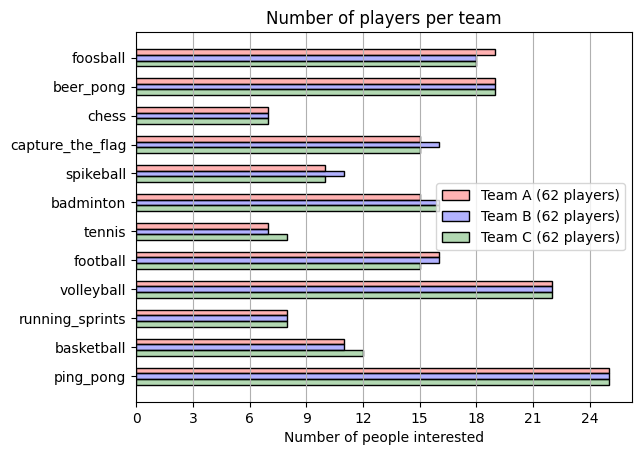

In [8]:
teams = setup.create_teams(num_teams=NUM_TEAMS)
fig, ax = plt.subplots()
# Update players that signed off after teams had already been created
update_player_signup_status(teams, "Stark Otter", "volleyball", False)
update_player_signup_status(teams, "Stark Otter", "capture_the_flag", False)
update_player_signup_status(teams, "Near Ladybug", "beer_pong", False)
update_player_signup_status(teams, "Alarmed Bird", "running_sprints", False)
for team in teams:
    team.plot_sports_num()
ax.set_title("Number of players per team")
ax.legend();
# interesting_nicks = ["Stark Otter", "Exotic Giraffe", "Outrageous Gar", "Pushy Bulldog", "Pink Narwhal", "Good Dolphin", "Edible Bloodhound", "Sneaky Quokka", "Quaint Koala", "Near Ladybug", "Cute Frog", "Real Mouse", "Awkward Cichlid", "Blank Tiffany", "Thankful Kakapo", "Deserted Chimpanzee"]
# for team in teams:
#     for nick in interesting_nicks:
#         if nick in team.player_df["nickname"].tolist():
#             print(f"{nick}: {team.team_letter}")
# teams[1].player_df.set_index("nickname").loc["Alarmed Bird"]


## Subteam generation

Now we're getting to the spicy stuff!

We can generate the subteams for each main team, but there's a few caveats:

- Some of the sports are going to happen simultaneously, which is accounted for by the SportEvent class keeping book about that, and weights that are assigned while subteams are drawn.
- Some players have only chosen one sport. To make sure they can attend that, we are also adjusting their weights while being drawn.
- Some of the sports do not have traditional subteam generation, which we need to account for.

### Generate the subteams for each sport

For running/sprints, everyone is on their own, and we have different events.\
As a first iteration, we just group everyone to be in their own subteam.\
Conveniently, all reserve players are also taking part in the other concurrent events.

Same with chess.

In [9]:
from helper_functions.setup import generate_all_subteams, try_switch_players
hf.DATA_NOW.reload()
hf.LOGGER.setLevel("INFO")
all_subteams = []
for team in teams:
    print(f"MAIN: {team.name}")
    subteams = generate_all_subteams(team)
    # Fix a scheduling issue:
    try_switch_subteam("Front Labradoodle", "Outrageous Gar", "beer_pong", subteams)
    # The following solves a conflict for Fast Havanese
    try_switch_players("Joint Coati", "Snappy Crab", "volleyball", subteams)
    try_switch_players("Joint Coati", "Fast Havanese", "running_sprints", subteams)
    # And for ill-fated meercat/Affectionat Chihuahua
    try_switch_players("Affectionate Chihuahua", "Ill-fated Meerkat", "basketball", subteams)
    team.add_subteam_keys(subteams)
    team.create_backup(overwrite=True)
    all_subteams.append(subteams)


MAIN: Team A
[sports_week: INFO] - running_sprints: Switched out Scientific Angelfish with Mushy Sparrow from A1 to AR
[sports_week: INFO] - running_sprints: Switched out Gripping Penguin with Exotic Giraffe from A1 to AR
[sports_week: WARNING] - The following players are still set as reserve for both football and tennis: {'Dishonest Fangtooth'}
[sports_week: INFO] - badminton: Switched out Soulful Ant with Monstrous Jackal from A5 to AR
[sports_week: INFO] - chess: Switched out Dishonest Fangtooth with Defiant Tortoise from A6 to AR
[sports_week: INFO] - beer_pong: Switched out Spicy Jaguar with Far-flung Sloth from A1 to AR
[sports_week: INFO] - foosball: Switched out Unwilling Starfish with Scientific Angelfish from A6 to AR
[sports_week: INFO] - beer_pong: Switched out Front Labradoodle with Outrageous Gar from A4 to A5
MAIN: Team B
[sports_week: WARNING] - The following players are still set as reserve for both volleyball and basketball: {'Affectionate Chihuahua'}
[sports_week: IN

In [10]:
df = hf.turn_series_list_to_dataframe([subteam.as_series for subteam in all_subteams[1] if subteam.is_reserve])
df["reserve_num"] = df["players"].apply(len)
df = df.sort_values("reserve_num")
all_players = [player for player_list in df["players"] for player in player_list]
names, counts = np.unique(all_players, return_counts=True)
print({player: count for player, count in zip(names, counts) if count > 1})
df[["sport", "team_key", "players", "reserve_num"]]


{'Joint Coati': 2, 'Neglected Harrier': 2, 'Real Mouse': 2, 'Unsteady Aardvark': 2}


,sport,team_key,players,reserve_num
0,ping_pong,B,[],0
1,basketball,B,[Ill-fated Meerkat],1
5,tennis,B,[Neglected Harrier],1
7,spikeball,B,[Real Mouse],1
8,chess,B,[Unsteady Aardvark],1
10,beer_pong,B,[Forthright Utonagan],1
2,running_sprints,B,"[Memorable Squirrel, Fast Havanese]",2
3,volleyball,B,"[Affectionate Chihuahua, Joint Coati]",2
4,football,B,"[Unsteady Aardvark, Snappy Crab]",2
9,capture_the_flag,B,"[Trivial Uguisu, Possible Anchovies]",2


In [ ]:
df = hf.DATA_NOW.players
for sport in hf.DATA_NOW.sport_events.keys():
    subdf = df[(df[f"subteam_{sport}"].fillna("") != "") & (df[f"subteam_{sport}"].fillna("") != "R")]
    proportion = len(subdf) / len(df)
    print(f"{sport}: {len(subdf)} ({proportion * 100:.1f}%)")
    # 11 % of players -> weight factor of 1
    suggested_weight = round(proportion * 100 / 11*2, 0)/2
    print(f"\tPoint-weight-factor: {suggested_weight}")


ping_pong: 75 (40.3%)
	Point-weight-factor: 3.5
basketball: 30 (16.1%)
	Point-weight-factor: 1.5
running_sprints: 18 (9.7%)
	Point-weight-factor: 1.0
volleyball: 60 (32.3%)
	Point-weight-factor: 3.0
football: 42 (22.6%)
	Point-weight-factor: 2.0
tennis: 18 (9.7%)
	Point-weight-factor: 1.0
badminton: 36 (19.4%)
	Point-weight-factor: 2.0
spikeball: 30 (16.1%)
	Point-weight-factor: 1.5
chess: 18 (9.7%)
	Point-weight-factor: 1.0
capture_the_flag: 42 (22.6%)
	Point-weight-factor: 2.0
beer_pong: 54 (29.0%)
	Point-weight-factor: 2.5
foosball: 36 (19.4%)
	Point-weight-factor: 2.0
